<a href="https://colab.research.google.com/github/jayro0414/Stock-Price-Prediction/blob/main/Stock_Price_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('apple.csv')

# looking at the first five rows of the data
print(df.head())
print('\n Shape of the data:')
print(df.shape)

# setting the index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

         Date       Open       High        Low      Close  Adj Close     Volume
0  2017-01-09  29.487499  29.857500  29.485001  29.747499  28.000782  134247600
1  2017-01-10  29.692499  29.844999  29.575001  29.777500  28.029018   97848400
2  2017-01-11  29.684999  29.982500  29.650000  29.937500  28.179623  110354400
3  2017-01-12  29.725000  29.825001  29.552500  29.812500  28.061970  108344800
4  2017-01-13  29.777500  29.905001  29.702499  29.760000  28.012548  104447600

 Shape of the data:
(1260, 7)


In [14]:
df.shape

(1260, 7)

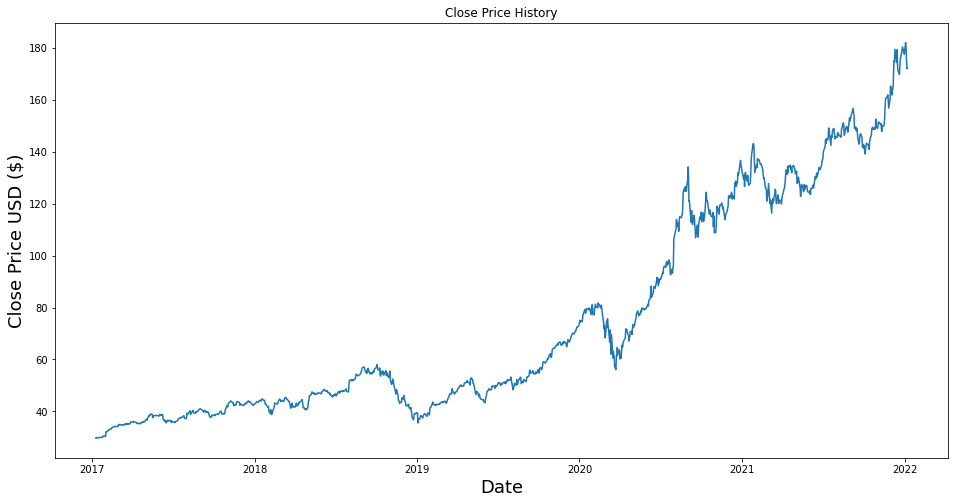

In [15]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

Moving Average

In [16]:
#creating new dataframe with date and closing price
d = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(df)):
  d['Date'][i] = df['Date'][i]
  d['Close'][i] = df['Close'][i]

#splitting training and validation sets
train = d[:1008]
valid = d[1008:]

#predicting stock prices
preds = []
for i in range(0, valid.shape[0]):
  a = train['Close'][len(train)-252+i:].sum() + sum(preds)
  b = a/252
  preds.append(b)

#calculating RMS
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('RMSE value on validation set:')
print(rms)

RMSE value on validation set:
38.36129957717764


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


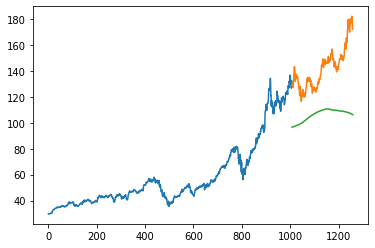

In [17]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

ARIMA

In [18]:
!pip install pmdarima
from pmdarima import auto_arima

#creating new training and validation set
train_new = train['Close']
valid_new = valid['Close']

#fitting model and predicting stock prices
model = auto_arima(train_new, start_q=1, max_p=3, m=12, start_P=0, seasonal=True,
                   d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_new)

pred = model.predict(n_periods=252)
pred = pd.DataFrame(pred, index = valid.index, columns=['Prediction'])

#calculating RMS
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(pred['Prediction'])),2)))
print('RMSE value on validation set:')
print(rms)

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 47.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=6.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4267.461, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4050.928, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4250.688, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3844.562, Time=1.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.47 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3859.264, Time=0.87 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3845.573, Time=1.57 sec
 ARIMA(1,1,1)(2,1

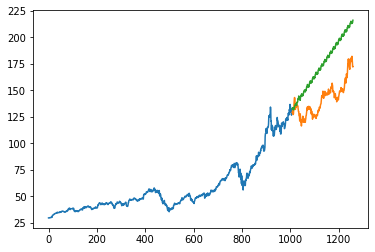

In [19]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(pred['Prediction'])

Long Short Term Memory

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    data['Date'][i] = df['Date'][i]
    data['Close'][i] = df['Close'][i]

#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = data.values
train = dataset[0:1008,:]
valid = dataset[1008:,:]

#splitting and scaling x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#creating and fitting the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting/modeling stock prices using past 60 from the train data
inputs = data[len(data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

#calcuating RMS
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

948/948 - 29s - loss: 0.0012 - 29s/epoch - 31ms/step


11.749718522791346

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


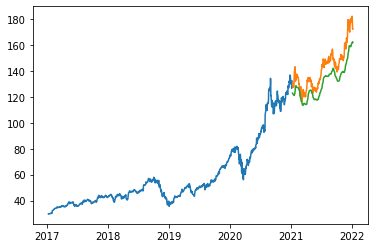

In [21]:
train = data[:1008]
valid = data[1008:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])